# Emissions Analysis for ST18 and ST14 Engines

This notebook analyzes emissions data across different engine tiers and operating conditions.
- Computes summary statistics (mean, max, std dev)
- Calculates skewness
- Detects outliers using the IQR method
- Visualizes distribution using violin plots

In [8]:
import pandas as pd
# Set pandas to display all rows
pd.set_option('display.max_rows', None)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew

## Load and Prepare Data

In [38]:
# Load the dataset
# df = pd.read_csv("LD084 LD070 LD071 LD076 LD078 LD079 LD094 RB016.csv")

# Map machine numbers to engine tiers
tier_mapping = {
    'LD070': 'Tier 4', 'LD071': 'Tier 4', 'LD076': 'Tier 4', 'LD078': 'Tier 4', 'LD094': 'Tier 4',
    'LD079': 'Tier 5', 'LD083': 'Tier 5', 'LD084': 'Tier 5',
    'RB016': 'Tier 3A', 'LD210': 'Tier 3A'
}
df['Tier'] = df['Machine Number'].map(tier_mapping)

# Extract Condition and Pollutant
df[['Condition', 'Pollutant']] = df['Category'].str.extract(r'^(IDLE|HIGH IDLE|STALL|DPM)\s*(CO|NO2|NOX|NO|mg/m3)?')

# Clean data
df_clean = df.dropna(subset=['Tier', 'Condition', 'Reading'])

In [39]:
df_clean

,Machine Number,Category,Reading,Tier,Condition,Pollutant
0,LD084,IDLE CO,0.00,Tier 5,IDLE,CO
1,LD084,IDLE NO,11.00,Tier 5,IDLE,NO
2,LD084,IDLE NO2,2.50,Tier 5,IDLE,NO2
3,LD084,IDLE NOX,3.83,Tier 5,IDLE,NOX
4,LD084,HIGH IDLE CO,3.00,Tier 5,HIGH IDLE,CO
5,LD084,HIGH IDLE NO,62.00,Tier 5,HIGH IDLE,NO
6,LD084,HIGH IDLE NO2,3.40,Tier 5,HIGH IDLE,NO2
7,LD084,HIGH IDLE NOX,6.03,Tier 5,HIGH IDLE,NOX
8,LD084,STALL CO,6.00,Tier 5,STALL,CO
9,LD084,STALL NO,137.00,Tier 5,STALL,NO


## Compute Summary Statistics

In [40]:
summary = (
    df_clean.groupby(['Tier', 'Condition', 'Pollutant'])['Reading']
    .agg(['mean', 'max', 'std'])
    .rename(columns={'mean': 'Mean', 'max': 'Max', 'std': 'StdDev'})
    .round(2)
    # .reset_index()
)
summary

Mean       Max    StdDev
Tier    Condition Pollutant                             
Tier 3A DPM       mg/m3       420.00    420.00       NaN
        HIGH IDLE CO          137.00    137.00       NaN
                  NO          167.00    167.00       NaN
                  NO2           0.70      0.70       NaN
                  NOX         167.70    167.70       NaN
        IDLE      CO          142.00    142.00       NaN
                  NO          209.00    209.00       NaN
                  NO2           0.09      0.09       NaN
                  NOX         209.90    209.90       NaN
        STALL     CO          107.00    107.00       NaN
                  NO          166.00    166.00       NaN
                  NO2           0.00      0.00       NaN
                  NOX         166.00    166.00       NaN
Tier 4  DPM       mg/m3       961.43   2830.00   1040.50
        HIGH IDLE CO           22.71     93.00     37.01
                  NO           38.86    105.00     36.05
                  NO2          14.33     75.90     27.45
                  NOX          53.19    180.90     61.55
        IDLE      CO           11.57     63.00     22.98
                  NO           31.57    154.00     56.11
                  NO2          11.86     64.90     23.78
                  NOX          43.43    218.90     79.80
        STALL     CO           90.00    387.00    158.47
                  NO          219.29    648.00    222.90
                  NO2          23.33     72.70     31.93
                  NOX         244.74    655.90    227.51
Tier 5  DPM       mg/m3      8256.67  20920.00  11134.43
        HIGH IDLE CO           25.67     73.00     41.00
                  NO           69.33    144.00     71.28
                  NO2          23.20     66.00     37.10
                  NOX          72.74    210.00    118.88
        IDLE      CO           10.33     31.00     17.90
                  NO           12.67     27.00     13.58
                  NO2          14.53     41.00     22.95
                  NOX          23.98     68.00     38.17
        STALL     CO           37.67    106.00     59.23
                  NO          116.33    210.00    105.53
                  NO2          25.30     63.00     33.10
                  NOX          94.94    273.00    154.23

## Add Skewness and Detect Outliers

In [41]:
def calculate_skew(group):
    return skew(group['Reading'].dropna(), bias=False)

df_clean['Skewness'] = df_clean.groupby(['Tier', 'Condition', 'Pollutant'])['Reading'].transform(
    lambda x: calculate_skew(pd.DataFrame({'Reading': x}))
)

def detect_outliers_iqr(group):
    Q1 = group['Reading'].quantile(0.25)
    Q3 = group['Reading'].quantile(0.75)
    IQR = Q3 - Q1
    return group[(group['Reading'] < Q1 - 1.5 * IQR) | (group['Reading'] > Q3 + 1.5 * IQR)]

outliers = df_clean.groupby(['Tier', 'Condition', 'Pollutant']).apply(detect_outliers_iqr).reset_index(drop=True)
outliers

C:\Users\19065963\AppData\Local\Temp\ipykernel_944\207972736.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Skewness'] = df_clean.groupby(['Tier', 'Condition', 'Pollutant'])['Reading'].transform(
C:\Users\19065963\AppData\Local\Temp\ipykernel_944\207972736.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  outliers = df_clean.groupby(['Tier', 'Condition', 'Pollutant']).apply(detect_outliers_iqr).reset_index(drop=True)


,Machine Number,Category,Reading,Tier,Condition,Pollutant,Skewness
0,LD071,HIGH IDLE CO,93.0,Tier 4,HIGH IDLE,CO,1.556999
1,LD078,HIGH IDLE NO2,75.9,Tier 4,HIGH IDLE,NO2,2.530602
2,LD078,HIGH IDLE NOX,180.9,Tier 4,HIGH IDLE,NOX,1.796766
3,LD071,IDLE CO,63.0,Tier 4,IDLE,CO,2.505537
4,LD078,IDLE NO,154.0,Tier 4,IDLE,NO,2.291380
5,LD078,IDLE NO2,64.9,Tier 4,IDLE,NO2,2.480376
6,LD078,IDLE NOX,218.9,Tier 4,IDLE,NOX,2.354961
7,LD094,STALL CO,387.0,Tier 4,STALL,CO,1.524451
8,LD094,STALL NO,648.0,Tier 4,STALL,NO,1.217601


## Save Results

In [42]:
summary.to_csv("emissions_summary.csv", index=False)
outliers.to_csv("emissions_outliers.csv", index=False)

## Visualize Emissions Distributions

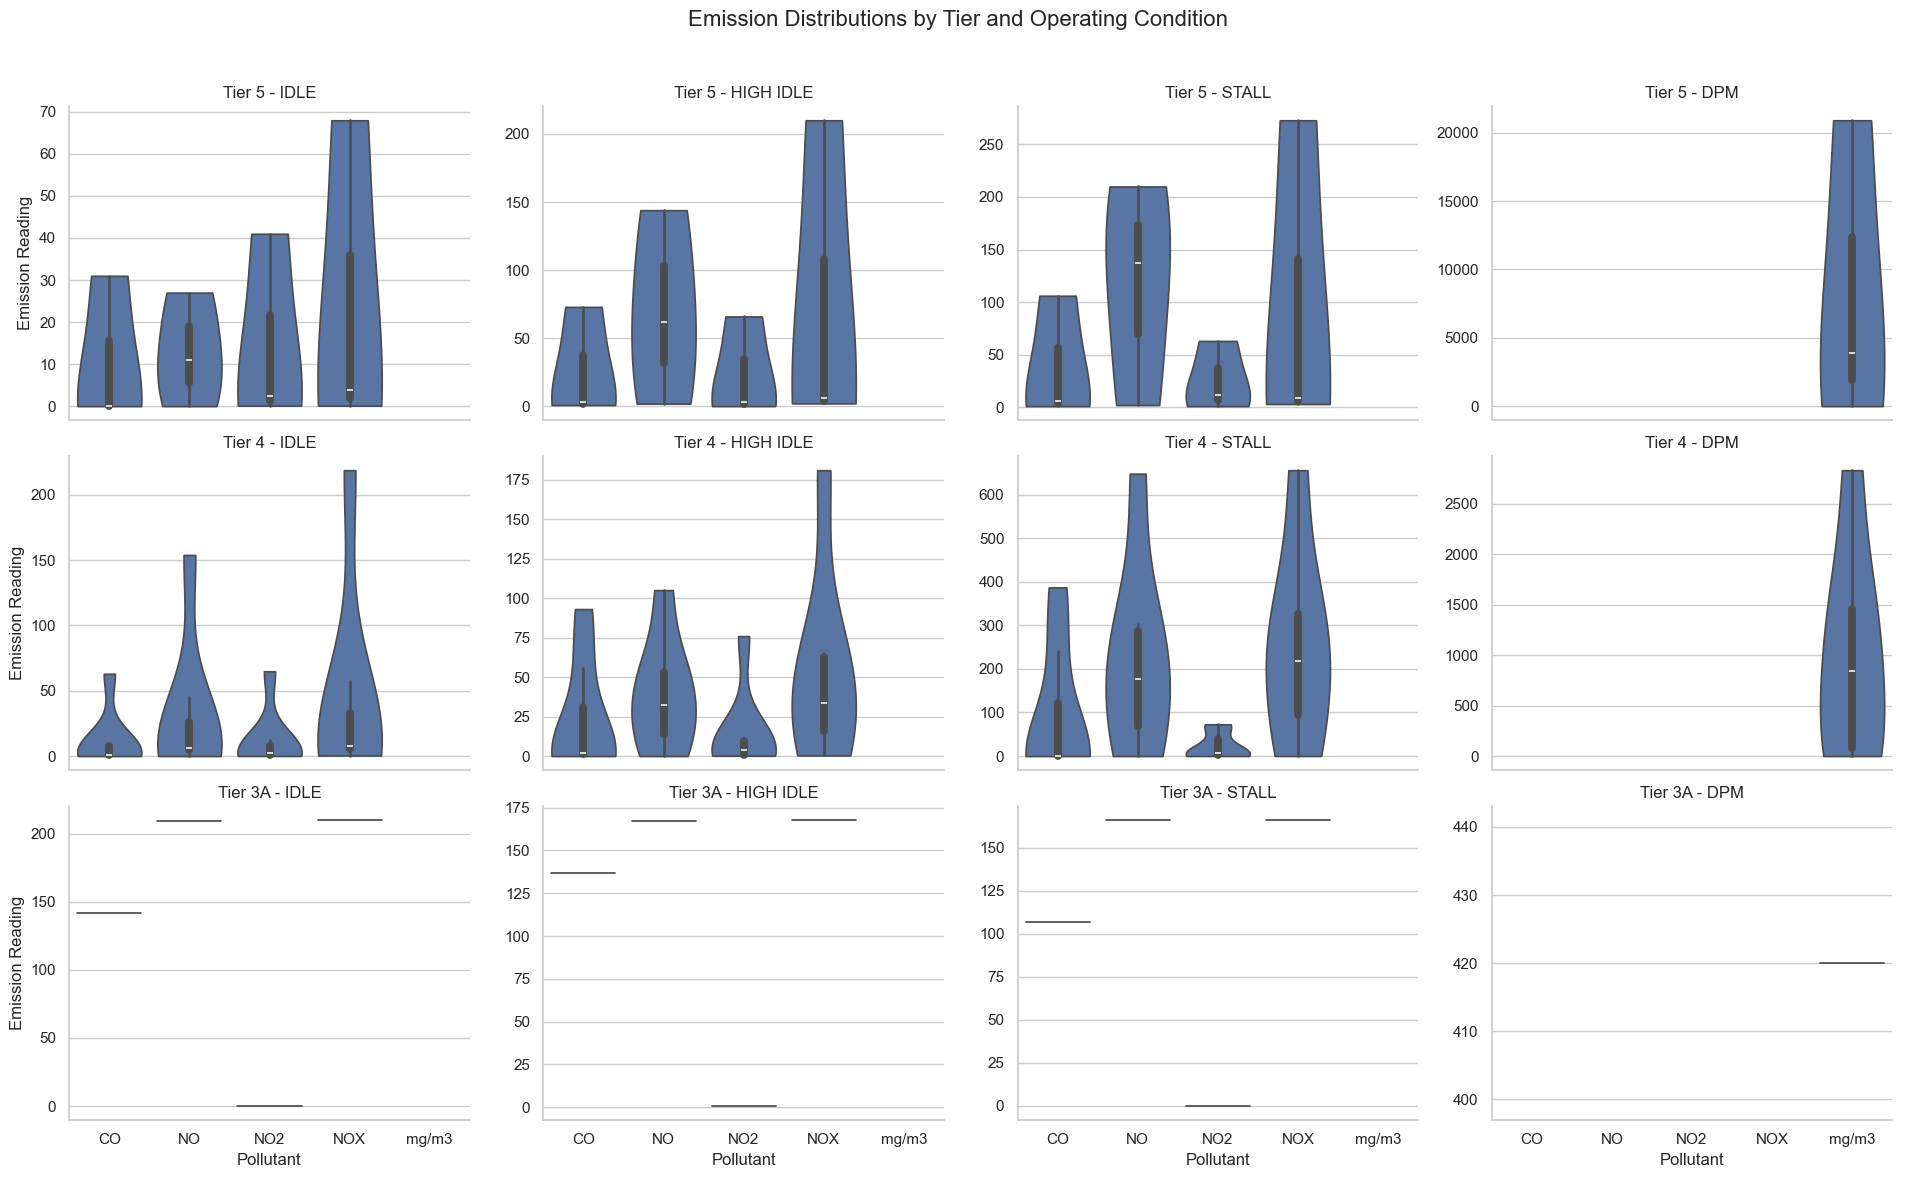

In [44]:
sns.set(style="whitegrid")
plot_data = df_clean[df_clean['Pollutant'].notna()]
g = sns.catplot(
    data=plot_data,
    x="Pollutant", y="Reading",
    col="Condition", row="Tier",
    kind="violin", cut=0, density_norm="count", inner="box", height=4, aspect=1.2,
    sharey=False
)
g.set_titles("{row_name} - {col_name}")
g.set_axis_labels("Pollutant", "Emission Reading")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Emission Distributions by Tier and Operating Condition", fontsize=16)
plt.show()

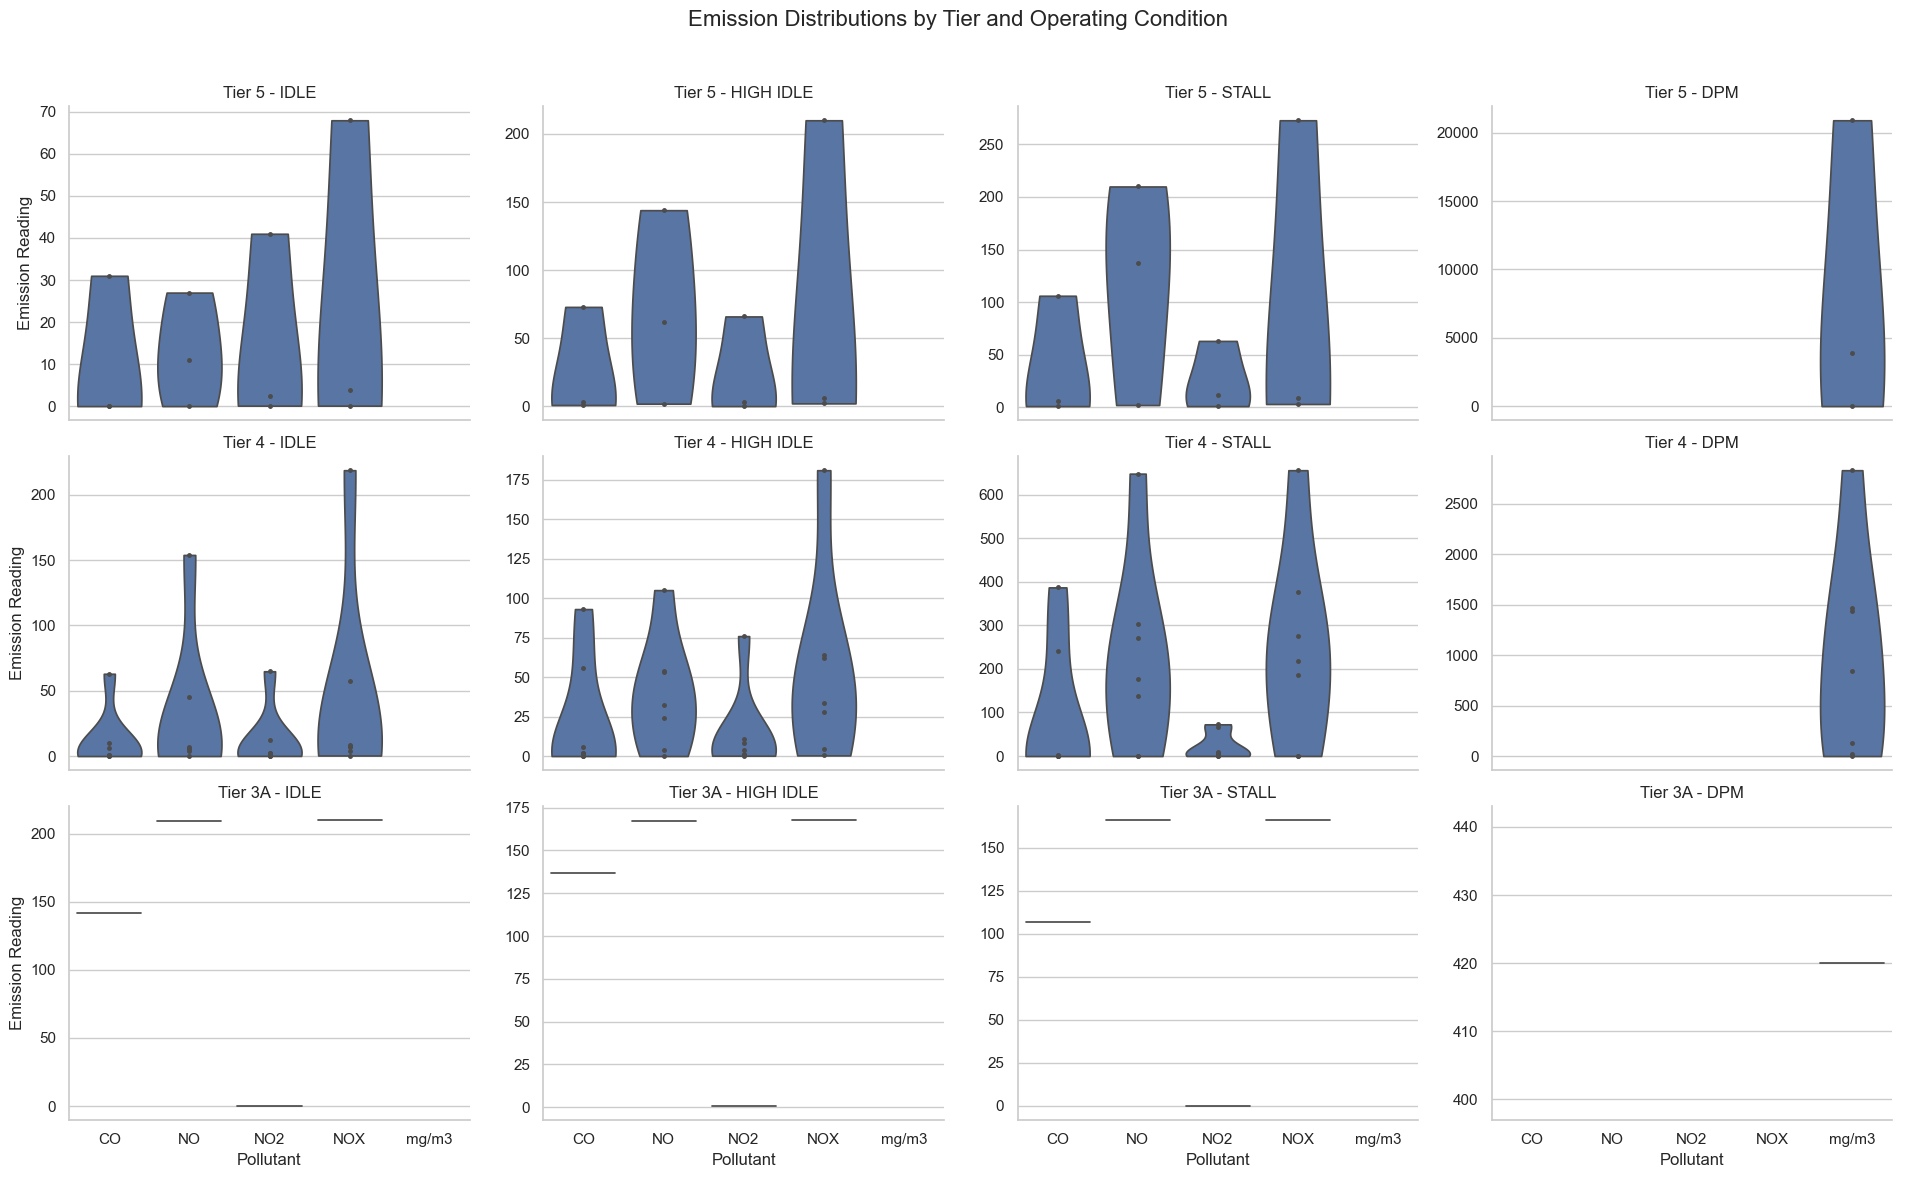

In [45]:
sns.set(style="whitegrid")
plot_data = df_clean[df_clean['Pollutant'].notna()]
g = sns.catplot(
    data=plot_data,
    x="Pollutant", y="Reading",
    col="Condition", row="Tier",
    kind="violin", cut=0, density_norm="count", inner="point", height=4, aspect=1.2,
    sharey=False
)
g.set_titles("{row_name} - {col_name}")
g.set_axis_labels("Pollutant", "Emission Reading")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Emission Distributions by Tier and Operating Condition", fontsize=16)
plt.show()

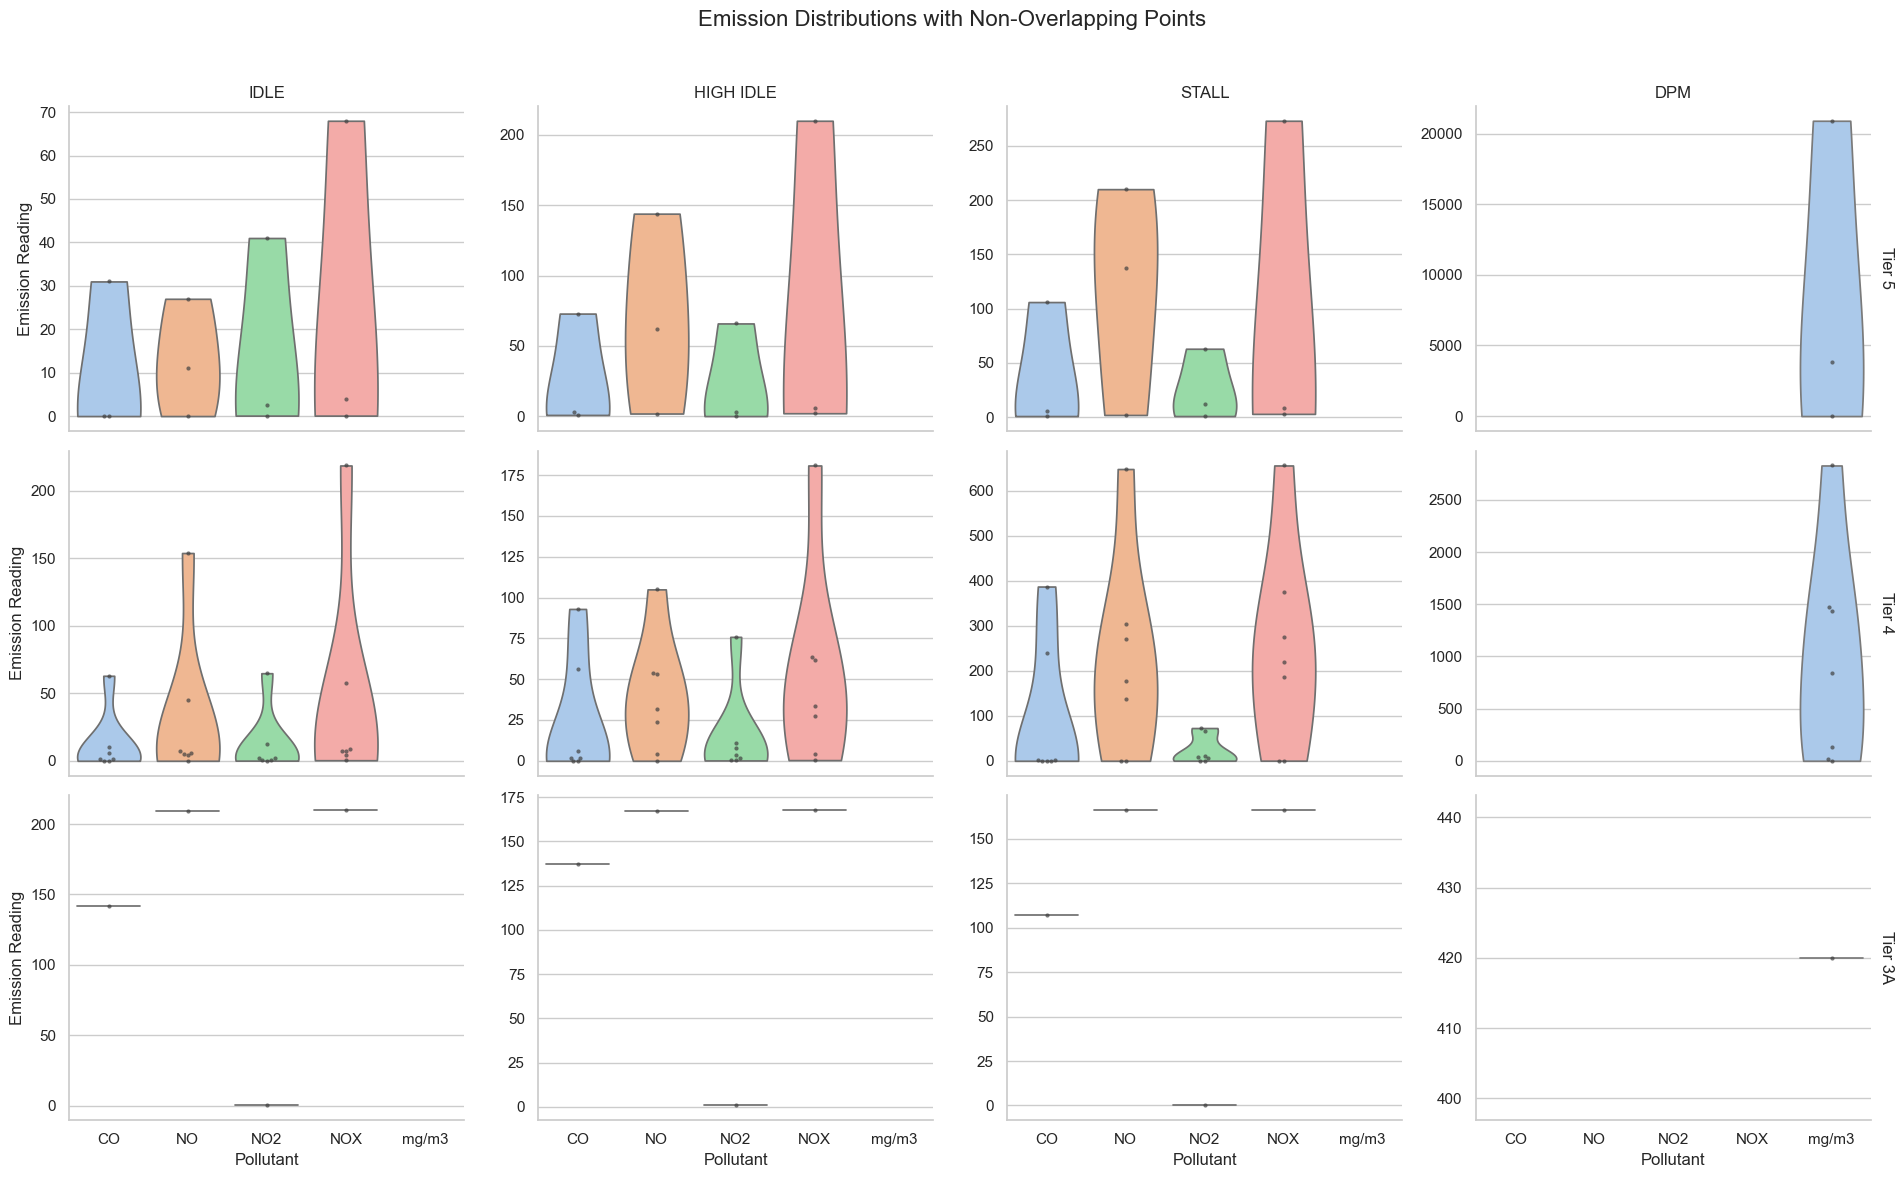

In [46]:
sns.set(style="whitegrid")

plot_data = df_clean[df_clean['Pollutant'].notna()]

# Create FacetGrid
g = sns.FacetGrid(
    data=plot_data,
    row="Tier", col="Condition",
    margin_titles=True,
    sharey=False,
    height=4, aspect=1.2
)

# Map violinplot to grid
g.map_dataframe(
    sns.violinplot,
    x="Pollutant", y="Reading",
    inner=None, cut=0, density_norm="count", palette="pastel", hue="Pollutant", legend=False
)

# Overlay swarmplot
g.map_dataframe(
    sns.swarmplot,
    x="Pollutant", y="Reading",
    size=3, color=".25", alpha=0.7
)

# Tidy up plot titles and labels
g.set_titles(row_template='{row_name}', col_template='{col_name}')
g.set_axis_labels("Pollutant", "Emission Reading")

plt.subplots_adjust(top=0.9)
g.fig.suptitle("Emission Distributions with Non-Overlapping Points", fontsize=16)
plt.show()